<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Стандартная-модель-медианного-значения" data-toc-modified-id="Стандартная-модель-медианного-значения-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Стандартная модель медианного значения</a></span></li><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-градиентного-бустинга" data-toc-modified-id="Модель-градиентного-бустинга-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель градиентного бустинга</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим необходимые библиотеки, затем получим данные о заказах такси по времени. Выясним, есть ли аномалии в данных или пропущенные значения, отсортируем данные по времени.

In [1]:
!pip install -q imblearn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tqdm import tqdm

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split , GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from imblearn.pipeline import make_pipeline

In [3]:
RANDOM_STATE = 32123
plt.rcParams["figure.figsize"] = (12, 9)

In [4]:
path = '/datasets/taxi.csv'
if os.path.exists(path):
    raw_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    input('Путь к файлу не существует')

In [5]:
raw_data.sort_index(inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


На данном этапе все данные о заказах такси идут по порядку во временном диапазоне. В данных отсутствуют провущенные значения.
Временной идекс в диапазоне от марта 2018 года до конца августа того же года (от 2018-03-01 до 2018-08-31).

## Анализ

В ходе анализа данных требуется выяснить прогнозируемость данных. Для этого в начале проведем ресемплирование, для более наглядного представления данных.
Далее найдем скользящее среднее и среднее отклоченеие.
Найдем те же параметры для разности временных данных для определения их прогнозируемости, т.к. разностные данные более стохастичны.
Затем проведем исследование тренда и сезонности данных.

In [6]:
data = raw_data.resample('1d').sum()

In [7]:
data['mean'] = data['num_orders'].shift().rolling(15).mean()
data['std'] = data['num_orders'].shift().rolling(15).std()

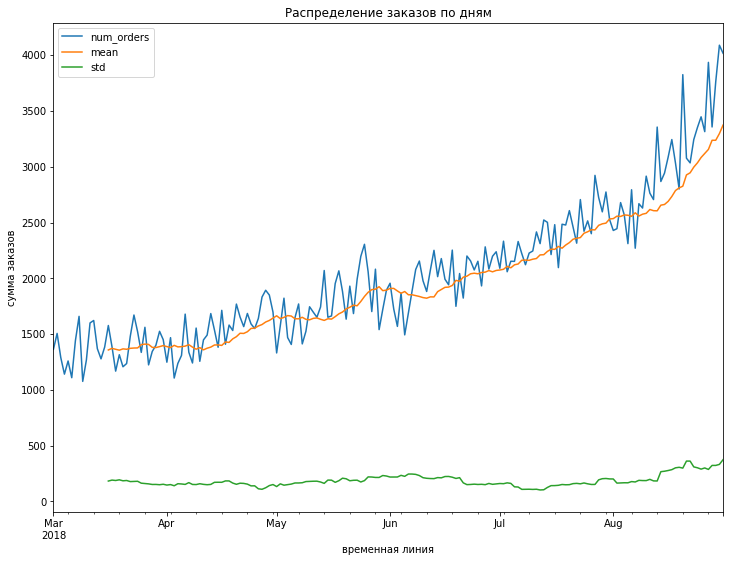

In [8]:
data.plot(xlabel='временная линия', ylabel='сумма заказов')
plt.title('Распределение заказов по дням')
plt.show()

Видно нелинейное увеличение заказов такси. У данного ряда наблюдается сезонность колебаний, шум и постоянный тренд. Этот ряд нестационарен. Такой ряд прогнозировать сложнее: его свойства меняются слишком быстро.

Для дополнительной проверки временного ряда на стационарность используем тест Дики-Фуллера.
Тест Дики-Фуллера является средством проверки стационарности временного ряда.

Нулевая гипотеза H0: p-value = 1 (существует единичный корень, ряд нестационарный).

Альтернативная гипотеза: H1: p-value < 0.05 (уровень значимости) (единичного корня нет, ряд стационарный).

Отвераем H0 на N процентном (N=1%, 5%, 10%) уровне значимости, если p-value < 0.05

In [9]:
# Проведем тест Дики-Фуллера на стационарность
result = adfuller(data['num_orders'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.728791
p-value: 1.000000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


p-value = 1 подтверждает вывод о том, что этот временной ряд не стационарен.

Далее попробуем взять разностный ряд и исследовать его стационарность. Это можеть быть важный параметр для предсказания заказов.

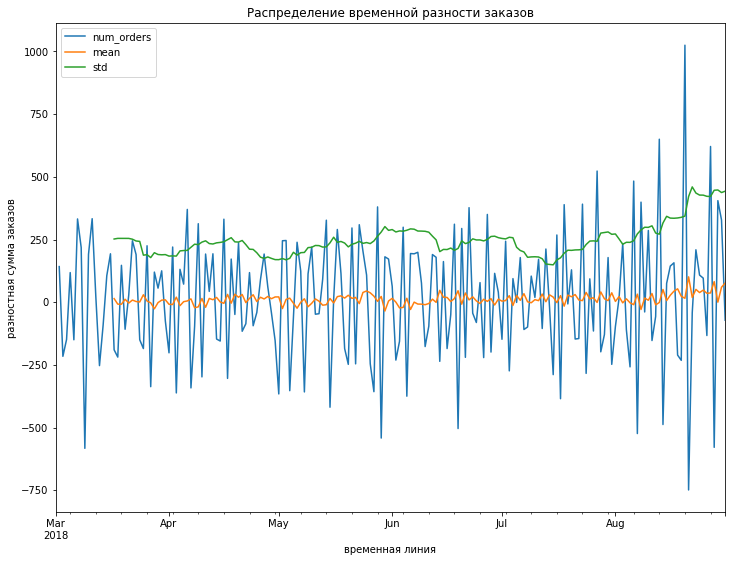

In [10]:
data_differenced = data - data.shift()
data_differenced['mean'] = data_differenced['num_orders'].shift().rolling(15).mean()
data_differenced['std'] = data_differenced['num_orders'].shift().rolling(15).std()
data_differenced.plot(xlabel='временная линия', ylabel='разностная сумма заказов') 
plt.title('Распределение временной разности заказов')
plt.show()

In [11]:
# Проведем тест Дики-Фуллера на стационарность
result = adfuller(data_differenced['num_orders'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.723182
p-value: 0.003799
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


Разностный ряд стационарен (его распределение не зависит от времени), следовательно данные вполне прогнозируемы. Его p-value меньше порогового значения alpha = 0.05 более чем в 10 раз! Т.е. средние и стандартные отклонения этого ряда не меняются со временем, следовательно его статистические характеристики стабильны во времени и можно исследовать и прогнозировать данный ряд.

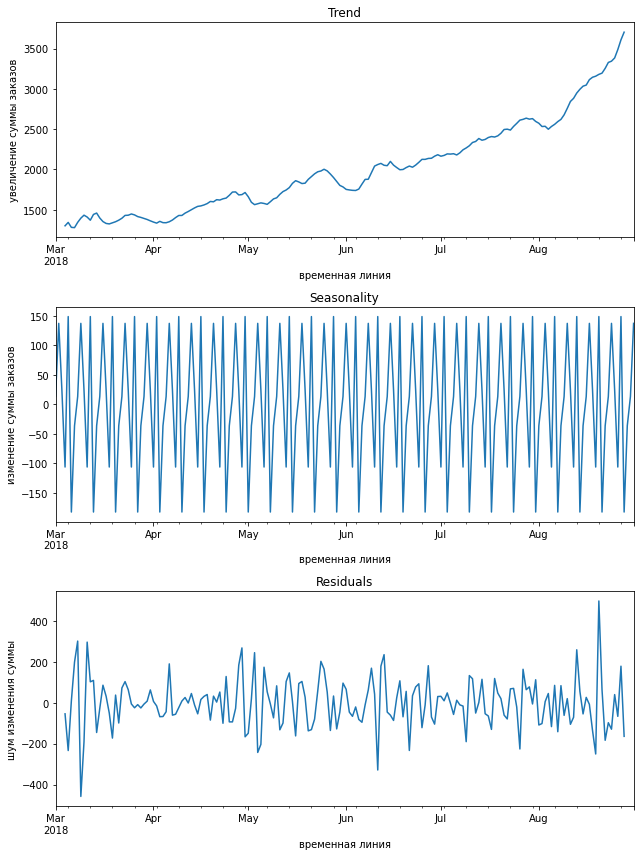

In [12]:
decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(9, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), ylabel='увеличение суммы заказов', xlabel='временная линия')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), ylabel='изменение суммы заказов', xlabel='временная линия')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), ylabel='шум изменения суммы', xlabel='временная линия') 
plt.title('Residuals')
plt.tight_layout()

Сезонность вызовов такси не вполне очевидна, но следует посмотреть на недельное распределение!

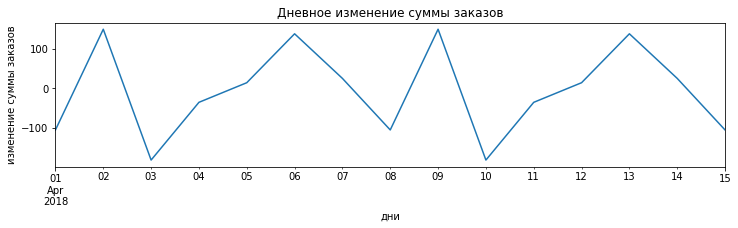

In [13]:
plt.subplot(311)
decomposed.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca(), ylabel='изменение суммы заказов', xlabel='дни')
plt.title('Дневное изменение суммы заказов');

Видно, что по пятницам заказов меньше всего.

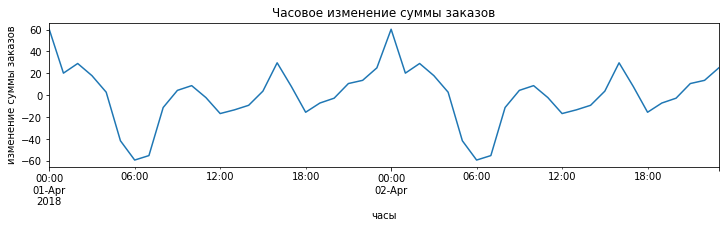

In [14]:
plt.subplot(311)
seasonal_decompose(raw_data.resample('1h').sum()).seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca(), ylabel='изменение суммы заказов', xlabel='часы')
plt.title('Часовое изменение суммы заказов');

Больше всего заказов вечером и в полночь.

В ходе анализа данных было выяснено, что заказы такси в целом увеличиваются со временем нелинейно, но с неизменным отклонением. Распределение временной разности заказов стохастично, поэтому данные прогнозируемы во времени. Сезонность распределения по временам года не наблюдается, однако по пятницам заказов меньше. Пик заказов призодится на полночь, а минимум заказов поступает в 6.00 утра.
Проанализировав трендовую компоненту можно сделать следующие выводы:

- Постоянный рост: Спрос на услуги такси показывает устойчивый восходящий тренд в течение всего периода.

- Сезонное влияние: Возможно, увеличение числа заказов связано с сезонными факторами, такими как отпуска или летние мероприятия, что часто приводит к росту пассажиропотока.

- Оценка масштаба: Пик в августе указывает на то, что заказы такси достигли своего максимума к этому времени года, что может потребовать дополнительных ресурсов или планирования для удовлетворения спроса.

- Планирование ресурсов: Таксопаркам следует планировать расширение парка или наращивание ресурсов для поддержания качества обслуживания в пиковые периоды.

- Маркетинговые и рекламные кампании: Если рост заказов является результатом маркетинговых усилий, это может служить подтверждением их эффективности.

- Стратегическое планирование: Тенденция роста может быть использована для стратегического планирования, например, для привлечения инвестиций или расширения бизнеса.

Сезонность заказов такси в аэропортах может быть обусловлена несколькими факторами:

- Время года: Летом и в праздничные периоды наблюдается увеличение числа путешественников, что ведет к росту спроса на такси в аэропортах. Это может объяснить общий восходящий тренд, особенно пик в августе, который может совпадать с периодом отпусков.

- Колебания в течение дня: Внутридневные колебания заказов такси могут быть связаны с расписанием полётов. Аэропорты имеют пиковые часы прилетов и вылетов, что влияет на спрос на такси.

- Колебания в течение недели: Спрос на такси также может меняться в зависимости от дня недели, с более высокими показателями в выходные и начале рабочей недели, когда увеличивается количество деловых поездок.

Эти колебания следует учитывать при планировании рабочих смен водителей, распределении автопарка и формировании стратегии управления спросом, чтобы обеспечить достаточное количество транспортных средств в пиковые периоды и оптимизировать ресурсы в более спокойные часы.

## Обучение

In [15]:
data = raw_data.resample('1H').sum()

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['difference'] = data['num_orders'].shift(1) - data['num_orders'].shift(2)
    return data

In [17]:
data = make_features(data, 24, 3)

Так как финальное тестирование произойдет в самом конце, то необходимо разделить данные на 3 части - train, valid, test

In [18]:
data.dropna(inplace=True)
X, y = data.drop(columns=['num_orders']), data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=False, test_size=1/9)
X_concatenated, y_concatenated = pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid])

### Стандартная модель медианного значения

In [19]:
predicted = np.ones(y_test.shape) * y_concatenated.median()

In [20]:
print("RMSE предсказания по медианному значению:", mean_squared_error(predicted, y_test)**.5)

RMSE предсказания по медианному значению: 87.21093811714634


### Линейная модель

In [21]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [22]:
predicted = lr_model.predict(X_valid)
print("RMSE валидационной выборки ленийной модели:", mean_squared_error(predicted, y_valid)**.5)

RMSE валидационной выборки ленийной модели: 34.28315349571165


### Модель случайного леса

In [23]:
best_rf_model1_dt_model, best_rf_model1_predicted_valid = None, None
best_rf_model1_result, best_rf_model1_est, best_rf_model1_depth = 10000, 0, 0

In [24]:
for n_estimators in tqdm(range(30, 131, 20)):
    for depth in range(6, 15, 4):
        rf_model1 = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=depth, n_estimators=n_estimators)
        rf_model1.fit(X_train, y_train)
        rf_model1_predictions_valid = rf_model1.predict(X_valid)
        result = mean_squared_error(rf_model1_predictions_valid, y_valid)**0.5
        if result < best_rf_model1_result:
            best_rf_model1 = rf_model1
            best_rf_model1_result = result
            best_rf_model1_est = n_estimators
            best_rf_model1_depth = depth
            best_rf_model1_predicted_valid = rf_model1_predictions_valid

100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


In [25]:
print(f"RMSE наилучшей модели случайного леса на валидационной выборке: {best_rf_model1_result}")

RMSE наилучшей модели случайного леса на валидационной выборке: 33.38039009195875


### Модель градиентного бустинга

In [26]:
%%time

params = {
    'loss_function':'RMSE', # objective function
    'eval_metric':'RMSE', # metric
    'verbose': 200, # output to stdout info about training process every 200 iterations
    'random_seed': RANDOM_STATE}
cbr = CatBoostRegressor(**params)
cbr.fit(
    X_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
    eval_set=(X_valid, y_valid), # data to validate on
    use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
    plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.062022
0:	learn: 34.7755271	test: 57.2206969	best: 57.2206969 (0)	total: 54.4ms	remaining: 54.3s
200:	learn: 17.8622143	test: 32.8114322	best: 32.8114322 (200)	total: 1.06s	remaining: 4.22s
400:	learn: 14.5703323	test: 32.2096213	best: 32.2056805 (391)	total: 2.06s	remaining: 3.08s
600:	learn: 12.2622538	test: 32.1107803	best: 31.9989984 (516)	total: 3.1s	remaining: 2.06s
800:	learn: 10.3724606	test: 31.9504217	best: 31.9450466 (712)	total: 4.16s	remaining: 1.03s
999:	learn: 8.9095478	test: 31.9799280	best: 31.8899664 (861)	total: 5.15s	remaining: 0us

bestTest = 31.88996638
bestIteration = 861

Shrink model to first 862 iterations.
CPU times: user 5.25 s, sys: 84.9 ms, total: 5.34 s
Wall time: 6.78 s


In [27]:
cbr_preds = cbr.predict(X_valid)

In [28]:
print("RMSE тестовой выборки:", mean_squared_error(cbr_preds, y_valid)**.5)

RMSE тестовой выборки: 31.889966383615906


В целом все 3 модели хорошо себя показали, а самая легковесная линейная модель показала лучший результат RMSE валидационной выборки ленийной модели = 61. Однако нет доверия линейной модели, поэтому я выберу модель градиентного бустинга CatBoost.

## Тестирование

In [29]:
best_model = cbr
best_model.fit(X_concatenated, y_concatenated);

Learning rate set to 0.050872
0:	learn: 37.8324820	total: 7.72ms	remaining: 7.71s
200:	learn: 20.2718569	total: 1.11s	remaining: 4.41s
400:	learn: 16.9752145	total: 2.22s	remaining: 3.31s
600:	learn: 14.7205567	total: 3.35s	remaining: 2.22s
800:	learn: 12.9820285	total: 4.48s	remaining: 1.11s
999:	learn: 11.4852244	total: 5.57s	remaining: 0us


In [30]:
best_model_predictions = cbr.predict(X_test)

In [31]:
print("RMSE тестовой выборки:", mean_squared_error(best_model_predictions, y_test)**.5)

RMSE тестовой выборки: 40.43048560502436


После дообучения модели на валидационных данных модель выдает отличный результат RMSE тестовой выборки: 40, что заметно меньше порогового значения.

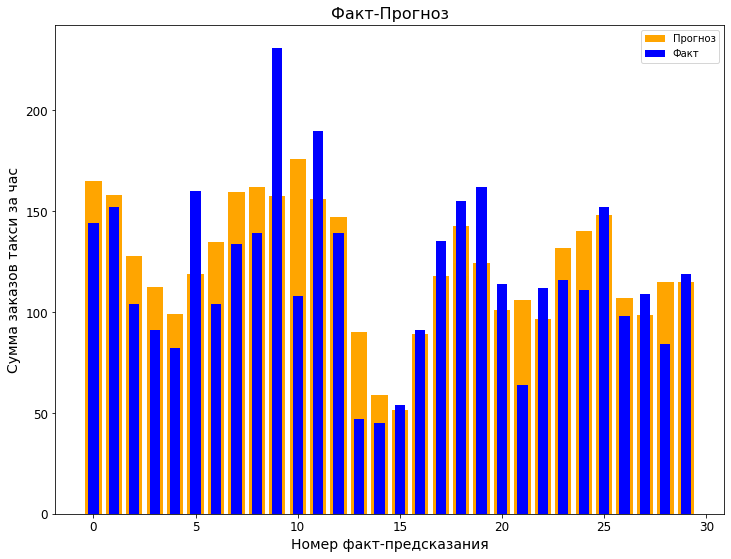

In [32]:
start = 0
end = 30

basic_df = y_test[start:end]
nn_df = best_model_predictions[start:end]

plt.bar(range(start, end), nn_df, color='orange', label='Прогноз')
plt.bar(range(start, end), basic_df, color='blue', width=0.5, label='Факт')

plt.legend()
plt.title('Факт-Прогноз', fontsize=16)
plt.xlabel('Номер факт-предсказания', fontsize=14)
plt.ylabel('Сумма заказов такси за час', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

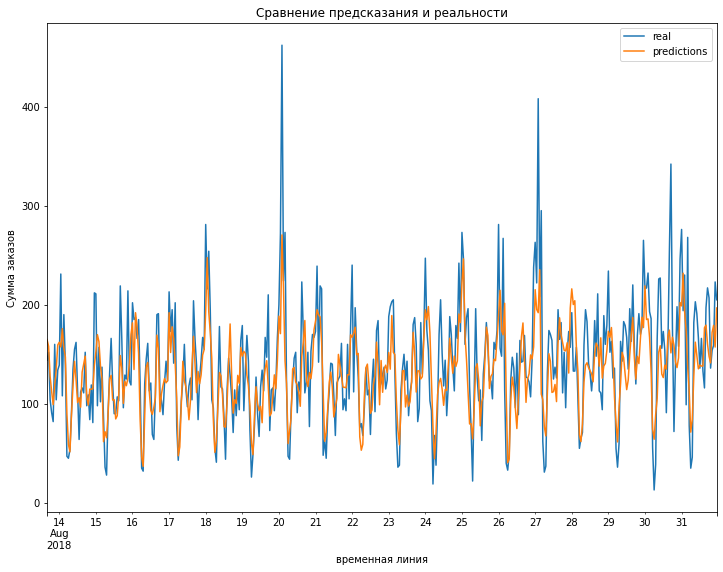

In [33]:
data_differenced = pd.DataFrame()
data_differenced['real'] = y_test
data_differenced['predictions'] = best_model_predictions
data_differenced.plot(xlabel='временная линия', ylabel='Сумма заказов') 
plt.title('Сравнение предсказания и реальности')
plt.show();

Общий вывод:
Для компании «Чётенькое такси» необходимо спрогнозировать количество заказов такси на следующий час. 
Требуется подобрать модель для такого предсказания.

Для создания модели были получены данные за 2018 год. В ходе анализа распределения данных было выявлено, что пик заказов приизодится на полуночь, минимум заказов приходится на 6 утра.
Меньше всего заказов приходится на пятницу.
В процессе подбора моделей были ислледованы 4 модели (линейная регрессия, градиентный бустинг и случайный лес решений), одна из которых просто медианное значение.
Лучшей моделью оказалась модель градиентного бустинга с RMSE на валидационных данных = 32. Данная модель легковесна, быстрее обучается и я выбрал её для дальнейшего тестирования. Перед тестированием модель была дообучена на валидационных данных. 
После дообучения модель показала на тестовый выборке RMSE = 40, что заметно ниже порогового значения. Модель была подобрана удачно и задача для заказчика решена.